In [403]:
import string
import pandas as pd
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer

import nltk
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from nltk import pos_tag
nltk.download('wordnet')
nltk.download('tagsets')
nltk.download('averaged_perceptron_tagger')

from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 90

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\natek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\natek\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\natek\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [106]:
df = pd.read_csv('tweet_list2.csv')
for n in df.columns:
    df[n] = df[n].astype(str)
df.dtypes
df.info()
df['user_name'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115511 entries, 0 to 115510
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   user_name   115511 non-null  object
 1   class       115511 non-null  object
 2   id          115511 non-null  object
 3   text        115511 non-null  object
 4   author_id   115511 non-null  object
 5   created_at  115511 non-null  object
dtypes: object(6)
memory usage: 5.3+ MB


WSJbusiness       1606
appleinsider       850
BloombergTV        850
wealth             850
ReutersBiz         850
                  ... 
repvalhoyle         10
JMoylanforGuam      10
NBCNetwork           7
RepJeffJackson       2
DNC                  1
Name: user_name, Length: 586, dtype: int64

Check for duplicates

In [107]:
df.duplicated()

0         False
1         False
2         False
3         False
4         False
          ...  
115506    False
115507    False
115508    False
115509    False
115510    False
Length: 115511, dtype: bool

Drop duplicates

In [108]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114634 entries, 0 to 115510
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   user_name   114634 non-null  object
 1   class       114634 non-null  object
 2   id          114634 non-null  object
 3   text        114634 non-null  object
 4   author_id   114634 non-null  object
 5   created_at  114634 non-null  object
dtypes: object(6)
memory usage: 6.1+ MB


Check class balance

In [109]:
df['class'].value_counts()

Politics - Conservative    31032
Politics - Liberal         26998
TV / movies                12007
Sports                     12000
Music                      11600
Business and finance        8452
Science / Technology        7550
Travel                      4995
Name: class, dtype: int64

Pre-processing

Data transformation functions

In [110]:
def strip_rt_user(text):
    if text[0:2] == "RT":
        colon = text.find(":")
        return text[colon+1:].lower()
    else:
        return text.lower()

def get_rt_user(text):
    if text[0:2] == "RT":
        colon = text.find(":")
        user = text[:colon]
        at = user.find("@")
        return (user[at+1:]).lower()
    else:
        return ""

def addHashTags(text):
    return "#" + text + "#"
    
def strip_links(text):
    tokens = text.split()
    
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def remove_characters(text, char_to_remove):
    str1 = ''.join(x for x in text if not x in char_to_remove)
    return str1

def remove_punctuation(text):
    text = remove_characters(text, string.punctuation)
    return text


In [111]:
df

,user_name,class,id,text,author_id,created_at
0,BennieGThompson,Politics - Liberal,1620584010991939584,"Today marks the 83rd anniversary of the first ever #SocialSecurity check, and Republic...",82453460,2023-02-01 00:45:11+00:00
1,BennieGThompson,Politics - Liberal,1620116251749269511,RT @VP: President Biden and I are just getting started. https://t.co/gLmNbpKGAN,82453460,2023-01-30 17:46:29+00:00
2,BennieGThompson,Politics - Liberal,1620116182618759168,"RT @RepJeffries: We will never negotiate away the health, safety or economic well-bein...",82453460,2023-01-30 17:46:12+00:00
3,BennieGThompson,Politics - Liberal,1620116109864357888,https://t.co/Ze7ePCUJJ2,82453460,2023-01-30 17:45:55+00:00
4,BennieGThompson,Politics - Liberal,1620061909113516036,https://t.co/ley5hNsz0y https://t.co/RFdTeGXGO1,82453460,2023-01-30 14:10:33+00:00
...,...,...,...,...,...,...
115506,RepLCD,Politics - Conservative,1611786100825006080,It was great to catch up with my friend @RepFeenstra last night -- we're ready to get ...,1583530102297600000,2023-01-07 18:05:26+00:00
115507,RepLCD,Politics - Conservative,1611615029660639233,Thank you #OR05 for placing your trust in me to represent you in the halls of Congress...,1583530102297600000,2023-01-07 06:45:40+00:00
115508,RepLCD,Politics - Conservative,1610791524807081986,A small minority is preventing the House from doing the work we were sent here to do. ...,1583530102297600000,2023-01-05 00:13:21+00:00
115509,RepLCD,Politics - Conservative,1610408428052295681,"As I take on the responsibility of serving #OR05, I'm very grateful to have my family ...",1583530102297600000,2023-01-03 22:51:03+00:00


In [329]:
df2 = df.copy()
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

# Constants 
min_word_size = 0
min_word_count = 0

# Make special user names and retweet names, and pull it out from the text tweet
df2['text2'] = df2['text'].apply(strip_rt_user)
df2['RT_user'] = df2['text'].apply(get_rt_user)
df2['RT_user#'] = df2['RT_user'].apply(lambda x: addHashTags(x) if x != "" else "")

# Lower case the text tweets
df2['text2'] = df2['text2'].str.lower()

# Strip out the meaningless links
df2['text2'] = df2['text2'].apply(lambda x: " ".join([n for n in x.split() if n[0:4] != "http"]))

# Strip any excess white space
df2['text2'] = df2['text2'].apply(lambda x: x.strip())

# Take out stop words
sw = set(stopwords.words('english'))
sw.update(['amp'])
df2['text2'] = df2['text2'].apply(lambda x: " ".join([n for n in x.split() if n not in sw]))

# Remove punctuation
df2['text2'] = df2['text2'].apply(lambda x: remove_punctuation(x))

# min length of characters for word
df2['text2'] = df2['text2'].apply(lambda x: " ".join([n for n in x.split() if len(n) >= min_word_size]))

# Make sure we don't have any random numbers
df2['text2'] = df2['text2'].apply(lambda x: " ".join([n for n in x.split() if n.isnumeric() == False]))

# Stem the words
#sb = SnowballStemmer(language='english')
#df2['text2'] = df2['text2'].apply(lambda x: " ".join([sb.stem(n) for n in x.split()]))

# Put it all together in a new column
df2['text2'] = df2['text2'] + " " + df2['RT_user#']

# Limit data to tweets that have greater than specific number of words
df2['word_count'] = df2['text2'].apply(lambda x: len(x))
df2 = df2[ df2['word_count'] >= min_word_count ]

# Make a new column, tokenize the words
df2['text3'] = df2['text2'].str.split()

# Make a new df
df3 = df2.copy()
df3['text3'] = df3['text3'].apply(lambda x: np.nan if len(x) == 0 else x)
df3 = df3.dropna().reset_index(drop=True) 
df3





,user_name,class,id,text,author_id,created_at,text2,RT_user,RT_user#,word_count,text3
0,BennieGThompson,Politics - Liberal,1620584010991939584,"Today marks the 83rd anniversary of the first ever #SocialSecurity check, and Republic...",82453460,2023-02-01 00:45:11+00:00,today marks 83rd anniversary first ever socialsecurity check republicans celebrating t...,,,180,"[today, marks, 83rd, anniversary, first, ever, socialsecurity, check, republicans, cel..."
1,BennieGThompson,Politics - Liberal,1620116251749269511,RT @VP: President Biden and I are just getting started. https://t.co/gLmNbpKGAN,82453460,2023-01-30 17:46:29+00:00,president biden getting started #vp#,vp,#vp#,36,"[president, biden, getting, started, #vp#]"
2,BennieGThompson,Politics - Liberal,1620116182618759168,"RT @RepJeffries: We will never negotiate away the health, safety or economic well-bein...",82453460,2023-01-30 17:46:12+00:00,never negotiate away health safety economic wellbeing american people #repjeffries#,repjeffries,#repjeffries#,83,"[never, negotiate, away, health, safety, economic, wellbeing, american, people, #repje..."
3,BennieGThompson,Politics - Liberal,1619330126361300993,The footage of Tyre Nichols killing is painful. I send my condolences to his family an...,82453460,2023-01-28 13:42:42+00:00,footage tyre nichols killing painful send condolences family friends justice must serv...,,,101,"[footage, tyre, nichols, killing, painful, send, condolences, family, friends, justice..."
4,BennieGThompson,Politics - Liberal,1619327606159179777,RT @CBCInstitute: Happy Birthday to our Chairman Congressman @BennieGThompson! In your...,82453460,2023-01-28 13:32:41+00:00,happy birthday chairman congressman benniegthompson 30th yr congress celebrate incredi...,cbcinstitute,#cbcinstitute#,108,"[happy, birthday, chairman, congressman, benniegthompson, 30th, yr, congress, celebrat..."
...,...,...,...,...,...,...,...,...,...,...,...
112722,RepLCD,Politics - Conservative,1611786100825006080,It was great to catch up with my friend @RepFeenstra last night -- we're ready to get ...,1583530102297600000,2023-01-07 18:05:26+00:00,great catch friend repfeenstra last night were ready get work amp deliver promises mad...,,,114,"[great, catch, friend, repfeenstra, last, night, were, ready, get, work, amp, deliver,..."
112723,RepLCD,Politics - Conservative,1611615029660639233,Thank you #OR05 for placing your trust in me to represent you in the halls of Congress...,1583530102297600000,2023-01-07 06:45:40+00:00,thank or05 placing trust represent halls congress solemn promise oregonians carry cons...,,,155,"[thank, or05, placing, trust, represent, halls, congress, solemn, promise, oregonians,..."
112724,RepLCD,Politics - Conservative,1610791524807081986,A small minority is preventing the House from doing the work we were sent here to do. ...,1583530102297600000,2023-01-05 00:13:21+00:00,small minority preventing house work sent do must get economy back track work get cost...,,,157,"[small, minority, preventing, house, work, sent, do, must, get, economy, back, track, ..."
112725,RepLCD,Politics - Conservative,1610408428052295681,"As I take on the responsibility of serving #OR05, I'm very grateful to have my family ...",1583530102297600000,2023-01-03 22:51:03+00:00,take responsibility serving or05 im grateful family side,,,57,"[take, responsibility, serving, or05, im, grateful, family, side]"


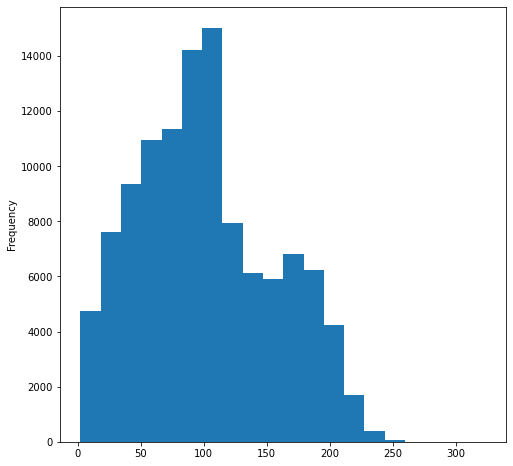

In [330]:
ax = df3['word_count'].plot.hist(figsize=(8,8), bins=20)

First try to predict Political affiliation.  Then move on to the others.

In [331]:
df3 = df3[(df3['class'] == 'Politics - Conservative') | (df3['class'] == 'Politics - Liberal')]
#df3

In [332]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df3['class_label'] = le.fit_transform(df3['class'])

<ipython-input-332-adeaad1ad0a3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['class_label'] = le.fit_transform(df3['class'])


In [333]:
labels = df3.groupby(['class', 'class_label'])['class',].count()
labels

,,class
class,class_label,
Politics - Conservative,0,30532
Politics - Liberal,1,26846


In [334]:
len(df3)
df3

,user_name,class,id,text,author_id,created_at,text2,RT_user,RT_user#,word_count,text3,class_label
0,BennieGThompson,Politics - Liberal,1620584010991939584,"Today marks the 83rd anniversary of the first ever #SocialSecurity check, and Republic...",82453460,2023-02-01 00:45:11+00:00,today marks 83rd anniversary first ever socialsecurity check republicans celebrating t...,,,180,"[today, marks, 83rd, anniversary, first, ever, socialsecurity, check, republicans, cel...",1
1,BennieGThompson,Politics - Liberal,1620116251749269511,RT @VP: President Biden and I are just getting started. https://t.co/gLmNbpKGAN,82453460,2023-01-30 17:46:29+00:00,president biden getting started #vp#,vp,#vp#,36,"[president, biden, getting, started, #vp#]",1
2,BennieGThompson,Politics - Liberal,1620116182618759168,"RT @RepJeffries: We will never negotiate away the health, safety or economic well-bein...",82453460,2023-01-30 17:46:12+00:00,never negotiate away health safety economic wellbeing american people #repjeffries#,repjeffries,#repjeffries#,83,"[never, negotiate, away, health, safety, economic, wellbeing, american, people, #repje...",1
3,BennieGThompson,Politics - Liberal,1619330126361300993,The footage of Tyre Nichols killing is painful. I send my condolences to his family an...,82453460,2023-01-28 13:42:42+00:00,footage tyre nichols killing painful send condolences family friends justice must serv...,,,101,"[footage, tyre, nichols, killing, painful, send, condolences, family, friends, justice...",1
4,BennieGThompson,Politics - Liberal,1619327606159179777,RT @CBCInstitute: Happy Birthday to our Chairman Congressman @BennieGThompson! In your...,82453460,2023-01-28 13:32:41+00:00,happy birthday chairman congressman benniegthompson 30th yr congress celebrate incredi...,cbcinstitute,#cbcinstitute#,108,"[happy, birthday, chairman, congressman, benniegthompson, 30th, yr, congress, celebrat...",1
...,...,...,...,...,...,...,...,...,...,...,...,...
112722,RepLCD,Politics - Conservative,1611786100825006080,It was great to catch up with my friend @RepFeenstra last night -- we're ready to get ...,1583530102297600000,2023-01-07 18:05:26+00:00,great catch friend repfeenstra last night were ready get work amp deliver promises mad...,,,114,"[great, catch, friend, repfeenstra, last, night, were, ready, get, work, amp, deliver,...",0
112723,RepLCD,Politics - Conservative,1611615029660639233,Thank you #OR05 for placing your trust in me to represent you in the halls of Congress...,1583530102297600000,2023-01-07 06:45:40+00:00,thank or05 placing trust represent halls congress solemn promise oregonians carry cons...,,,155,"[thank, or05, placing, trust, represent, halls, congress, solemn, promise, oregonians,...",0
112724,RepLCD,Politics - Conservative,1610791524807081986,A small minority is preventing the House from doing the work we were sent here to do. ...,1583530102297600000,2023-01-05 00:13:21+00:00,small minority preventing house work sent do must get economy back track work get cost...,,,157,"[small, minority, preventing, house, work, sent, do, must, get, economy, back, track, ...",0
112725,RepLCD,Politics - Conservative,1610408428052295681,"As I take on the responsibility of serving #OR05, I'm very grateful to have my family ...",1583530102297600000,2023-01-03 22:51:03+00:00,take responsibility serving or05 im grateful family side,,,57,"[take, responsibility, serving, or05, im, grateful, family, side]",0


In [335]:
def tag_and_lemmatize(text):
    newText = text
    newText = pos_tag(newText)
    newText = [(x[0], get_wordnet_pos(x[1])) for x in newText]
    lemma = nltk.stem.WordNetLemmatizer()
    newText = [(lemma.lemmatize(x[0], x[1])) for x in newText]
    return newText


In [336]:
df3['text4'] = df3['text3'].apply(tag_and_lemmatize)

<ipython-input-336-973889fcb34c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['text4'] = df3['text3'].apply(tag_and_lemmatize)


In [337]:
df3['text4'][0]

['today',
 'mark',
 '83rd',
 'anniversary',
 'first',
 'ever',
 'socialsecurity',
 'check',
 'republicans',
 'celebrate',
 'try',
 'cut',
 'vital',
 'program',
 'determine',
 'protect',
 'expand',
 'program',
 'american',
 'worker',
 'pay',
 'every',
 'paycheck']

In [338]:
df3

,user_name,class,id,text,author_id,created_at,text2,RT_user,RT_user#,word_count,text3,class_label,text4
0,BennieGThompson,Politics - Liberal,1620584010991939584,"Today marks the 83rd anniversary of the first ever #SocialSecurity check, and Republic...",82453460,2023-02-01 00:45:11+00:00,today marks 83rd anniversary first ever socialsecurity check republicans celebrating t...,,,180,"[today, marks, 83rd, anniversary, first, ever, socialsecurity, check, republicans, cel...",1,"[today, mark, 83rd, anniversary, first, ever, socialsecurity, check, republicans, cele..."
1,BennieGThompson,Politics - Liberal,1620116251749269511,RT @VP: President Biden and I are just getting started. https://t.co/gLmNbpKGAN,82453460,2023-01-30 17:46:29+00:00,president biden getting started #vp#,vp,#vp#,36,"[president, biden, getting, started, #vp#]",1,"[president, biden, get, start, #vp#]"
2,BennieGThompson,Politics - Liberal,1620116182618759168,"RT @RepJeffries: We will never negotiate away the health, safety or economic well-bein...",82453460,2023-01-30 17:46:12+00:00,never negotiate away health safety economic wellbeing american people #repjeffries#,repjeffries,#repjeffries#,83,"[never, negotiate, away, health, safety, economic, wellbeing, american, people, #repje...",1,"[never, negotiate, away, health, safety, economic, wellbeing, american, people, #repje..."
3,BennieGThompson,Politics - Liberal,1619330126361300993,The footage of Tyre Nichols killing is painful. I send my condolences to his family an...,82453460,2023-01-28 13:42:42+00:00,footage tyre nichols killing painful send condolences family friends justice must serv...,,,101,"[footage, tyre, nichols, killing, painful, send, condolences, family, friends, justice...",1,"[footage, tyre, nichols, kill, painful, send, condolence, family, friends, justice, mu..."
4,BennieGThompson,Politics - Liberal,1619327606159179777,RT @CBCInstitute: Happy Birthday to our Chairman Congressman @BennieGThompson! In your...,82453460,2023-01-28 13:32:41+00:00,happy birthday chairman congressman benniegthompson 30th yr congress celebrate incredi...,cbcinstitute,#cbcinstitute#,108,"[happy, birthday, chairman, congressman, benniegthompson, 30th, yr, congress, celebrat...",1,"[happy, birthday, chairman, congressman, benniegthompson, 30th, yr, congress, celebrat..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
112722,RepLCD,Politics - Conservative,1611786100825006080,It was great to catch up with my friend @RepFeenstra last night -- we're ready to get ...,1583530102297600000,2023-01-07 18:05:26+00:00,great catch friend repfeenstra last night were ready get work amp deliver promises mad...,,,114,"[great, catch, friend, repfeenstra, last, night, were, ready, get, work, amp, deliver,...",0,"[great, catch, friend, repfeenstra, last, night, be, ready, get, work, amp, deliver, p..."
112723,RepLCD,Politics - Conservative,1611615029660639233,Thank you #OR05 for placing your trust in me to represent you in the halls of Congress...,1583530102297600000,2023-01-07 06:45:40+00:00,thank or05 placing trust represent halls congress solemn promise oregonians carry cons...,,,155,"[thank, or05, placing, trust, represent, halls, congress, solemn, promise, oregonians,...",0,"[thank, or05, place, trust, represent, hall, congress, solemn, promise, oregonian, car..."
112724,RepLCD,Politics - Conservative,1610791524807081986,A small minority is preventing the House from doing the work we were sent here to do. ...,1583530102297600000,2023-01-05 00:13:21+00:00,small minority preventing house work sent do must get economy back track work get cost...,,,157,"[small, minority, preventing, house, work, sent, do, must, get, economy, back, track, ...",0,"[small, minority, prevent, house, work, send, do, must, get, economy, back, track, wor..."
112725,RepLCD,Politics - Conservative,1610408428052295681,"As I take on the responsibility of serving #OR05, I'm very grateful to have my family ...",1583530102297600000,2023-01-03 22:51:03+00:00,take re

In [339]:
#df3.to_csv('all_lemmatized.csv')

In [340]:
#df3 = pd.read_csv("all_lemmatized.csv")

In [341]:
df4 = df3.groupby(['user_name', 'class_label', 'class']).agg({'text4': 'sum'}).reset_index()
df4

,user_name,class_label,class,text4
0,AOC,1,Politics - Liberal,"[excite, humble, share, even, select, serve, repraskins, house, oversight, committee, ..."
1,Acyn,1,Politics - Liberal,"[chad, comer, appear, coown, property, james, comer, receive, small, amount, covid, mo..."
2,AustinScottGA08,0,Politics - Conservative,"[today, international, holocaust, remembrance, day, please, join, honor, million, peop..."
3,BarackObama,1,Politics - Liberal,"[along, mourn, tyre, support, family, u, mobilize, last, change, learn, community, rei..."
4,BennieGThompson,1,Politics - Liberal,"[today, mark, 83rd, anniversary, first, ever, socialsecurity, check, republicans, cele..."
...,...,...,...,...
482,staceyabrams,1,Politics - Liberal,"[across, south, disability, poverty, yoke, georgia, help, eliminate, hbcs, wait, list,..."
483,stkirsch,0,Politics - Conservative,"[response, joel, smalley, mp, regard, evidence, safety, effectiveness, covid, vaccine,..."
484,tedcruz,0,Politics - Conservative,"[mayorkas, impeach, month, ago, thank, sentedcruz, put, extra, emphasis, issue, #fairi..."
485,thedailybeast,1,Politics - Liberal,"[favorite, part, jimmykimmel, ask, first, guest, pamela, anderson, ever, meet, mypillo..."


In [342]:
df4['count_text_4'] = df4['text4'].apply(len)
df4

,user_name,class_label,class,text4,count_text_4
0,AOC,1,Politics - Liberal,"[excite, humble, share, even, select, serve, repraskins, house, oversight, committee, ...",7371
1,Acyn,1,Politics - Liberal,"[chad, comer, appear, coown, property, james, comer, receive, small, amount, covid, mo...",5426
2,AustinScottGA08,0,Politics - Conservative,"[today, international, holocaust, remembrance, day, please, join, honor, million, peop...",1262
3,BarackObama,1,Politics - Liberal,"[along, mourn, tyre, support, family, u, mobilize, last, change, learn, community, rei...",9587
4,BennieGThompson,1,Politics - Liberal,"[today, mark, 83rd, anniversary, first, ever, socialsecurity, check, republicans, cele...",938
...,...,...,...,...,...
482,staceyabrams,1,Politics - Liberal,"[across, south, disability, poverty, yoke, georgia, help, eliminate, hbcs, wait, list,...",8957
483,stkirsch,0,Politics - Conservative,"[response, joel, smalley, mp, regard, evidence, safety, effectiveness, covid, vaccine,...",5963
484,tedcruz,0,Politics - Conservative,"[mayorkas, impeach, month, ago, thank, sentedcruz, put, extra, emphasis, issue, #fairi...",5211
485,thedailybeast,1,Politics - Liberal,"[favorite, part, jimmykimmel, ask, first, guest, pamela, anderson, ever, meet, mypillo...",7388


In [425]:
X = df4['text4']
y = df4['class_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5)

In [426]:
X_train

67     [im, horrify, event, aguadilla, yesterday, private, security, assault, shot, activist,...
462    [thank, jimjordan, american, people, deserve, answer, get, them, nashs, first, flight,...
26     [today, organizational, meeting, transportdems, announce, subcommittee, assignment, el...
155    [im, invite, joe, cramera, frankenmuth, resident, dry, bean, grower, amp, resident, ne...
217    [pandemic, act, pass, house, move, country, beyond, operating, emergency, due, covid19...
                                                 ...                                            
238    [allow, social, security, medicare, sacrifice, altar, extreme, maga, republican, house...
4      [today, mark, 83rd, anniversary, first, ever, socialsecurity, check, republicans, cele...
245    [big, news, ive, appoint, serve, house, committees, agriculture, natural, resource, lo...
277    [statement, freedom, health, care, worker, act, start, soon, committee, reconvene, con...
309    [proud, stand, alongsid

In [427]:
# Import the relevant vectorizer class
from sklearn.feature_extraction.text import TfidfVectorizer

def dummy_fun(doc):
    return doc

# Instantiate a vectorizer with max_features=10
# (we are using the default token pattern)
tfidf = TfidfVectorizer(analyzer='word', tokenizer=dummy_fun, 
                        preprocessor=dummy_fun, token_pattern=None, 
                        ngram_range=(1,3), max_features=750)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train)

# Visually inspect the vectorized data
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

,#dineshdsouza#,118th,118th congress,able,abortion,abuse,access,accountability,accountable,across,...,world,would,write,year,year ago,yesterday,yet,york,you,young
0,0.0,0.018544,0.019159,0.021549,0.057476,0.000000,0.033890,0.000000,0.000000,0.084965,...,0.016650,0.059316,0.000000,0.137046,0.000000,0.056410,0.000000,0.164399,0.000000,0.022114
1,0.0,0.000000,0.000000,0.000000,0.073883,0.000000,0.000000,0.000000,0.003852,0.017245,...,0.020276,0.030098,0.000000,0.055631,0.031647,0.019082,0.025585,0.006673,0.036123,0.022442
2,0.0,0.010257,0.010598,0.000000,0.010598,0.000000,0.046866,0.000000,0.000000,0.007833,...,0.009210,0.032810,0.030970,0.027566,0.009583,0.020802,0.011621,0.000000,0.000000,0.012232
3,0.0,0.063323,0.065423,0.014717,0.000000,0.000000,0.069437,0.000000,0.000000,0.009671,...,0.056856,0.020255,0.019119,0.093597,0.023665,0.000000,0.000000,0.000000,0.012155,0.000000
4,0.0,0.013027,0.013459,0.000000,0.013459,0.000000,0.035713,0.000000,0.053334,0.019896,...,0.000000,0.041671,0.000000,0.122534,0.012171,0.000000,0.000000,0.000000,0.012503,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020044,0.000000,...,0.000000,0.000000,0.000000,0.078946,0.018297,0.000000,0.000000,0.000000,0.018796,0.000000
239,0.0,0.035382,0.036556,0.000000,0.000000,0.000000,0.000000,0.021434,0.000000,0.000000,...,0.000000,0.014147,0.000000,0.261488,0.181812,0.000000,0.000000,0.000000,0.050938,0.000000
240,0.0,0.050276,0.051943,0.000000,0.000000,0.022579,0.015314,0.000000,0.017153,0.051190,...,0.015047,0.000000,0.000000,0.123853,0.031314,0.000000,0.037974,0.000000,0.000000,0.000000
241,0.0,0.020828,0.021518,0.000000,0.021518,0.000000,0.000000,0.075702,0.021317,0.031810,...,0.056101,0.049966,0.031443,0.097952,0.038918,0.000000,0.000000,0.184647,0.019990,0.000000


First try a Naive Bayes Classifier

In [428]:
# Import relevant class and function
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

# Instantiate a MultinomialNB classifier
baseline_model = ComplementNB()

# Evaluate the classifier on X_train_vectorized and y_train
baseline_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)
baseline_cv.mean()

0.9547619047619047

In [429]:
# Fit the vectorizer on X_train["text"] and transform it
X_test_vectorized = tfidf.transform(X_test)

# Visually inspect the vectorized data
# pd.DataFrame.sparse.from_spmatrix(X_test_vectorized, columns=tfidf.get_feature_names())

In [430]:
# Evaluate the classifier on X_train_vectorized and y_train
baseline_cv = cross_val_score(baseline_model, X_test_vectorized, y_test)
baseline_cv.mean()

0.950765306122449